In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
!pip install torch torch-geometric pandas scikit-learn
!pip install networkx spacy
!python -m spacy download en_core_web_sm
!pip install --upgrade gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 45.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [35]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [36]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import nltk
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
from nltk.sentiment import SentimentIntensityAnalyzer
import yfinance as yf
import networkx as nx
import spacy
import sqlite3
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

Preprocess Data

News Data

Financial news data from https://www.kaggle.com/datasets/notlucasp/financial-news-headlines

In [37]:
news_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/reuters_headlines.csv")

# look at first 100 rows for prototyping
news_df_small = news_df.head(100)

In [38]:
# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

def process_news(df):
    processed_data = []

    for _, row in df.iterrows():
        doc = nlp(row['Headlines'] + " " + row['Description'])

        # Extract entities
        entities = [(ent.text, ent.label_) for ent in doc.ents]

        # Extract relationships (simplified as verb phrases)
        relationships = [chunk.text for chunk in doc.noun_chunks if chunk.root.dep_ == "dobj"]

        # Perform sentiment analysis
        sentiment = sia.polarity_scores(doc.text)

        processed_data.append({
            'time': row['Time'],
            'entities': entities,
            'relationships': relationships,
            'sentiment': sentiment
        })

    return pd.DataFrame(processed_data)

# Assuming your dataframe is called 'news_df'
processed_news = process_news(news_df_small)

Create entities and relationships

In [39]:
from collections import defaultdict

def create_entity_relationship_structure(processed_news):
    entities = defaultdict(lambda: {'mentions': 0, 'sentiment': 0, 'connections': set()})
    relationships = defaultdict(int)

    for _, row in processed_news.iterrows():
        for entity, entity_type in row['entities']:
            entities[entity]['mentions'] += 1
            entities[entity]['sentiment'] += row['sentiment']['compound']

        for rel in row['relationships']:
            relationships[rel] += 1

        # Connect co-occurring entities
        for i, (entity1, _) in enumerate(row['entities']):
            for entity2, _ in row['entities'][i+1:]:
                entities[entity1]['connections'].add(entity2)
                entities[entity2]['connections'].add(entity1)

    # Normalize sentiment
    for entity in entities:
        if entities[entity]['mentions'] > 0:
            entities[entity]['sentiment'] /= entities[entity]['mentions']

    return dict(entities), dict(relationships)

entities, relationships = create_entity_relationship_structure(processed_news)

Build Knowledge Graph

In [40]:
import networkx as nx

def build_knowledge_graph(entities, relationships):
    G = nx.Graph()

    # Add nodes (entities)
    for entity, data in entities.items():
        G.add_node(entity, **data)

    # Add edges (relationships)
    for entity, data in entities.items():
        for connected_entity in data['connections']:
            G.add_edge(entity, connected_entity, weight=1)

    # Add relationship nodes
    for rel, count in relationships.items():
        G.add_node(rel, type='relationship', count=count)

    return G

knowledge_graph = build_knowledge_graph(entities, relationships)

# You can now analyze the graph, e.g.:
print(f"Number of nodes: {len(knowledge_graph.nodes)}")
print(f"Number of edges: {len(knowledge_graph.edges)}")
print(f"Most connected entity: {max(knowledge_graph.degree, key=lambda x: x[1])}")

Number of nodes: 572
Number of edges: 1255
Most connected entity: ('U.S.', 108)


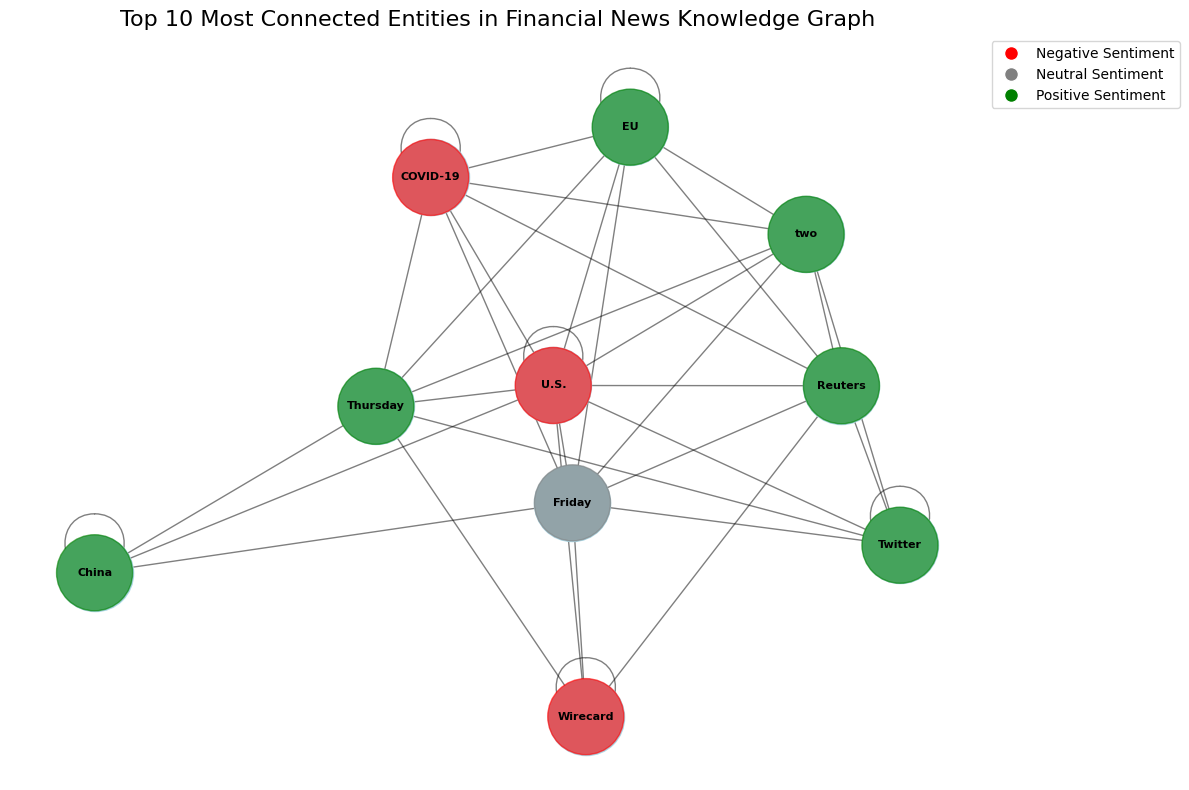

In [41]:
def visualize_knowledge_graph(G, top_n=10):
    # Get top N most connected entities
    top_entities = sorted(G.degree, key=lambda x: x[1], reverse=True)[:top_n]
    top_entity_names = [entity for entity, _ in top_entities]

    # Create a subgraph with these entities
    subgraph = G.subgraph(top_entity_names)

    # Set up the plot
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(subgraph)

    # Draw nodes
    nx.draw_networkx_nodes(subgraph, pos, node_size=3000, node_color='lightblue')
    nx.draw_networkx_labels(subgraph, pos, font_size=8, font_weight="bold")

    # Draw edges
    nx.draw_networkx_edges(subgraph, pos, width=1, alpha=0.5)

    # Add a title
    plt.title("Top {} Most Connected Entities in Financial News Knowledge Graph".format(top_n), fontsize=16)

    # Add a legend
    sentiment_legend = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Negative Sentiment'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Neutral Sentiment'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=10, label='Positive Sentiment')
    ]
    plt.legend(handles=sentiment_legend, loc='upper left', bbox_to_anchor=(1, 1))

    # Color nodes based on sentiment
    node_colors = []
    for node in subgraph.nodes():
        sentiment = subgraph.nodes[node].get('sentiment', 0)
        if sentiment < -0.05:
            color = 'red'
        elif sentiment > 0.05:
            color = 'green'
        else:
            color = 'gray'
        node_colors.append(color)

    nx.draw_networkx_nodes(subgraph, pos, node_size=3000, node_color=node_colors, alpha=0.6)

    # Adjust the plot layout and display
    plt.tight_layout()
    plt.axis('off')
    plt.show()

# Assuming 'knowledge_graph' is the graph we created earlier
visualize_knowledge_graph(knowledge_graph, top_n=10)

Financial Data

In [42]:
# Function to download and preprocess data
def download_and_structure(tickers, days=2500):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    data = yf.download(tickers, start=start_date, end=end_date)
    df_list = []
    for ticker in tickers:
        df = pd.DataFrame({
            'date': data.index,
            'ticker': ticker,
            'open': data['Open'][ticker],
            'high': data['High'][ticker],
            'low': data['Low'][ticker],
            'close': data['Close'][ticker],
            'volume': data['Volume'][ticker],
            'adj_close': data['Adj Close'][ticker]
        })
        df_list.append(df)

    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df = combined_df.sort_values(['date', 'ticker']).reset_index(drop=True)
    return combined_df

In [43]:
# Function to save the dataframe to SQLite
def save_to_sqlite(df, db_name='financial_data.db', table_name='stock_data'):
    conn = sqlite3.connect(db_name)
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    conn.close()

tickers = ["AAPL", "MSFT", "AMZN", "GOOG", "GOOGL", "TSLA", "NVDA", "META", "UNH", "JNJ",
           "V", "JPM", "PG", "HD", "MA", "BAC", "XOM", "CVX", "LLY", "PFE"]

In [44]:
# Selection of tickers
tickers = ["AAPL", "MSFT", "AMZN", "GOOG", "GOOGL", "TSLA", "NVDA", "META", "UNH", "JNJ",
           "V", "JPM", "PG", "HD", "MA", "BAC", "XOM", "CVX", "LLY", "PFE"]

# Download and preprocess data
structured_data = download_and_structure(tickers)

# Save preprocessed data to SQLite database
save_to_sqlite(structured_data)

[*********************100%***********************]  20 of 20 completed


In [45]:
# Function to load data from SQLite
def load_from_sqlite(db_name='financial_data.db', table_name='stock_data'):
    conn = sqlite3.connect(db_name)
    df = pd.read_sql(f"SELECT * FROM {table_name}", conn)
    conn.close()
    return df

# Load data for GNN from the SQLite database
df = load_from_sqlite()

In [46]:
df.head()

,date,ticker,open,high,low,close,volume,adj_close
0,2017-11-20 00:00:00+00:00,AAPL,42.572498,42.639999,42.389999,42.494999,65049600,40.031967
1,2017-11-20 00:00:00+00:00,AMZN,56.488499,56.671001,56.127499,56.315498,43278000,56.315498
2,2017-11-20 00:00:00+00:00,BAC,26.740000,26.840000,26.540001,26.740000,46328800,22.700806
3,2017-11-20 00:00:00+00:00,CVX,114.769997,115.029999,114.440002,114.720001,4634200,85.854652
4,2017-11-20 00:00:00+00:00,GOOG,51.013000,51.130501,50.875000,50.918999,19070000,50.794258


In [47]:
def prepare_for_gnn(df):
    for col in ['open', 'high', 'low', 'close', 'volume', 'adj_close']:
        df[f'{col}_lag1'] = df.groupby('ticker')[col].shift(1)
    df['returns'] = df.groupby('ticker')['adj_close'].pct_change()
    df = df.dropna().reset_index(drop=True)
    return df

df = prepare_for_gnn(df)

df.head()

,date,ticker,open,high,low,close,volume,adj_close,open_lag1,high_lag1,low_lag1,close_lag1,volume_lag1,adj_close_lag1,returns
0,2017-11-21 00:00:00+00:00,AAPL,42.695000,43.424999,42.695000,43.285000,100525200,40.776180,42.572498,42.639999,42.389999,42.494999,65049600.0,40.031967,0.018590
1,2017-11-21 00:00:00+00:00,AMZN,56.643002,57.000000,56.410000,56.974499,49588000,56.974499,56.488499,56.671001,56.127499,56.315498,43278000.0,56.315498,0.011702
2,2017-11-21 00:00:00+00:00,BAC,26.799999,26.860001,26.690001,26.730000,57749100,22.692318,26.740000,26.840000,26.540001,26.740000,46328800.0,22.700806,-0.000374
3,2017-11-21 00:00:00+00:00,CVX,115.139999,115.860001,114.919998,115.169998,4596000,86.191406,114.769997,115.029999,114.440002,114.720001,4634200.0,85.854652,0.003922
4,2017-11-21 00:00:00+00:00,GOOG,51.165501,51.755501,51.132751,51.724499,21940000,51.597782,51.013000,51.130501,50.875000,50.918999,19070000.0,50.794258,0.015819


In [48]:
# Define features and target columns
feature_columns = ['open', 'high', 'low', 'close', 'volume', 'adj_close',
                   'open_lag1', 'high_lag1', 'low_lag1', 'close_lag1', 'volume_lag1', 'adj_close_lag1']
target_column = 'returns'

# Normalize features
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Fill NaNs in the target column
df[target_column] = df[target_column].fillna(0)

# Create adjacency matrix based on correlation of returns
tickers = df['ticker'].unique()
corr_matrix = df.pivot(index='date', columns='ticker', values='returns').corr().abs()
adj_matrix = (corr_matrix > 0.5).astype(int)

df.head()

,date,ticker,open,high,low,close,volume,adj_close,open_lag1,high_lag1,low_lag1,close_lag1,volume_lag1,adj_close_lag1,returns
0,2017-11-21 00:00:00+00:00,AAPL,-0.965875,-0.964323,-0.961931,-0.961449,0.412155,-0.937510,-0.966908,-0.970609,-0.964463,-0.967845,0.104335,-0.943547,0.018590
1,2017-11-21 00:00:00+00:00,AMZN,-0.853592,-0.856173,-0.850299,-0.851244,-0.029550,-0.806141,-0.854772,-0.858718,-0.852537,-0.856478,-0.084437,-0.811354,0.011702
2,2017-11-21 00:00:00+00:00,BAC,-1.093831,-1.096295,-1.092203,-1.094722,0.041220,-1.084170,-1.094487,-1.096607,-1.093601,-1.094801,-0.057985,-1.084246,-0.000374
3,2017-11-21 00:00:00+00:00,CVX,-0.382684,-0.387242,-0.374062,-0.382752,-0.419700,-0.569192,-0.385137,-0.393332,-0.377435,-0.385846,-0.419500,-0.571548,0.003922
4,2017-11-21 00:00:00+00:00,GOOG,-0.897686,-0.897955,-0.893253,-0.893508,-0.269301,-0.849746,-0.898894,-0.902901,-0.895331,-0.899963,-0.294334,-0.856176,0.015819


Create Graph

In [49]:
# Create PyTorch Geometric Data objects
def create_pyg_data(df, adj_matrix, window_size=10):
    data_list = []
    tickers = df['ticker'].unique()
    n_tickers = len(tickers)

    for i in range(window_size, len(df) // n_tickers):
        start_idx = i * n_tickers - window_size
        end_idx = i * n_tickers

        x = torch.FloatTensor(df[feature_columns].values[start_idx:end_idx])
        # Adjusted target to match output size
        y = torch.FloatTensor(df[target_column].values[start_idx:end_idx])

        edge_index = []
        for i in range(n_tickers):
            for j in range(n_tickers):
                if adj_matrix.iloc[i, j] == 1 and i != j:
                    edge_index.append([i, j])

        edge_index = torch.LongTensor(edge_index).t().contiguous()
        max_index = x.size(0) - 1
        edge_index = edge_index[:, (edge_index < max_index).all(0)]

        # Ensure x and y have the same node count
        if x.shape[0] == y.shape[0]:
            data = Data(x=x, y=y, edge_index=edge_index)
            data_list.append(data)

    return data_list

data_list = create_pyg_data(df, adj_matrix)
split_index = int(len(data_list) * 0.8)

# Split data chronologically
train_data = data_list[:split_index]
test_data = data_list[split_index:]

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [50]:
# Step 3: Define the Temporal GNN model
class TemporalGNN(nn.Module):
    def __init__(self, num_features, hidden_dim, output_dim, num_gcn_layers=2, num_lstm_layers=1):
        super(TemporalGNN, self).__init__()
        self.num_gcn_layers = num_gcn_layers
        self.gcn_layers = nn.ModuleList([GCNConv(num_features if i == 0 else hidden_dim, hidden_dim)
                                         for i in range(num_gcn_layers)])
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch_size = data.num_graphs
        num_nodes = x.size(0) // batch_size

        for i in range(self.num_gcn_layers):
            x = F.relu(self.gcn_layers[i](x, edge_index))

        x = x.view(batch_size, num_nodes, -1)
        x, _ = self.lstm(x)
        x = x.reshape(-1, x.size(-1))
        x = self.fc(x)
        return x.view(-1)

# Step 4: Training loop with debugging
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)

        # Debugging shapes
        #print(f"Batch x shape: {batch.x.shape}, edge_index shape: {batch.edge_index.shape}")
        #print(f"Model output shape: {out.shape}, Target shape: {batch.y.shape}")

        # Ensure the output and target have the same shape
        if out.shape != batch.y.shape:
            print(f"Shape mismatch: Model output shape {out.shape}, Target shape {batch.y.shape}")
            continue

        loss = criterion(out, batch.y)
        if not torch.isfinite(loss):
            print("Encountered non-finite loss, skipping batch")
            continue

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Instantiate the model, optimizer, and loss function
model = TemporalGNN(num_features=len(feature_columns), hidden_dim=64, output_dim=1, num_gcn_layers=2, num_lstm_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')

Epoch 10/100, Train Loss: 0.0006
Epoch 20/100, Train Loss: 0.0006
Epoch 30/100, Train Loss: 0.0006
Epoch 40/100, Train Loss: 0.0005
Epoch 50/100, Train Loss: 0.0003
Epoch 60/100, Train Loss: 0.0003
Epoch 70/100, Train Loss: 0.0003
Epoch 80/100, Train Loss: 0.0002
Epoch 90/100, Train Loss: 0.0002
Epoch 100/100, Train Loss: 0.0002


In [51]:
def test(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in test_loader:
            out = model(batch)

            # Ensure the output and target have the same shape
            if out.shape != batch.y.shape:
                print(f"Shape mismatch: Model output shape {out.shape}, Target shape {batch.y.shape}")
                continue

            loss = criterion(out, batch.y)
            total_loss += loss.item()

            predictions.extend(out.cpu().numpy())
            actuals.extend(batch.y.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    return avg_loss, predictions, actuals

In [52]:
# Instantiate the model, optimizer, and loss function
model = TemporalGNN(num_features=len(feature_columns), hidden_dim=64, output_dim=1, num_gcn_layers=2, num_lstm_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training and testing the model
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    test_loss, predictions, actuals = test(model, test_loader, criterion)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Final evaluation
final_test_loss, final_predictions, final_actuals = test(model, test_loader, criterion)
print(f'Final Test Loss: {final_test_loss:.4f}')

Epoch 10/100, Train Loss: 0.0006, Test Loss: 0.0004
Epoch 20/100, Train Loss: 0.0004, Test Loss: 0.0004
Epoch 30/100, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 40/100, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 50/100, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 60/100, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 70/100, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 80/100, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 90/100, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 100/100, Train Loss: 0.0002, Test Loss: 0.0002
Final Test Loss: 0.0002


Mean Squared Error: 0.0002
Mean Absolute Error: 0.0090
R-squared Score: 0.5148


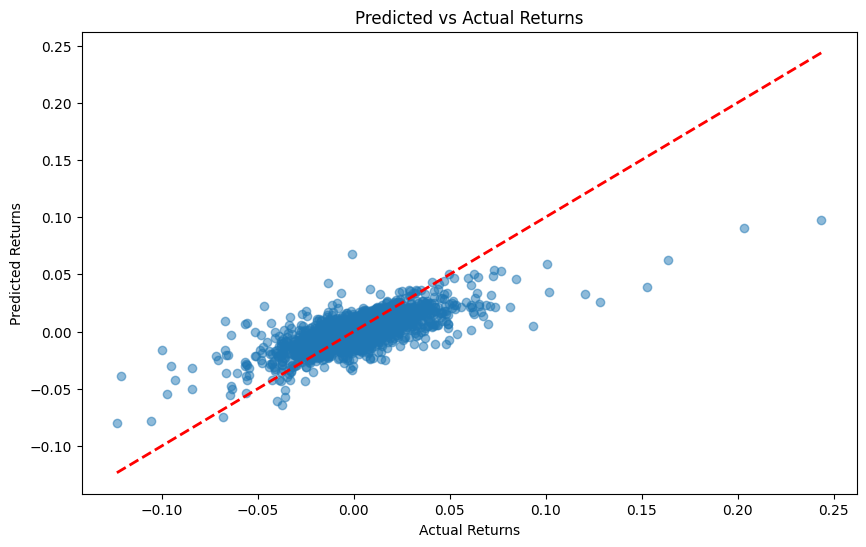

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Calculate additional metrics
mse = mean_squared_error(final_actuals, final_predictions)
mae = mean_absolute_error(final_actuals, final_predictions)
r2 = r2_score(final_actuals, final_predictions)

print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared Score: {r2:.4f}')

# Visualize predictions vs actuals
plt.figure(figsize=(10, 6))
plt.scatter(final_actuals, final_predictions, alpha=0.5)
plt.plot([min(final_actuals), max(final_actuals)], [min(final_actuals), max(final_actuals)], 'r--', lw=2)
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title('Predicted vs Actual Returns')
plt.show()